<a href="https://colab.research.google.com/github/rezendervp/chemical-engineering/blob/main/Lid_Cavity_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Courant Number is 0.3


100%|██████████| 5000/5000 [00:18<00:00, 269.95it/s]


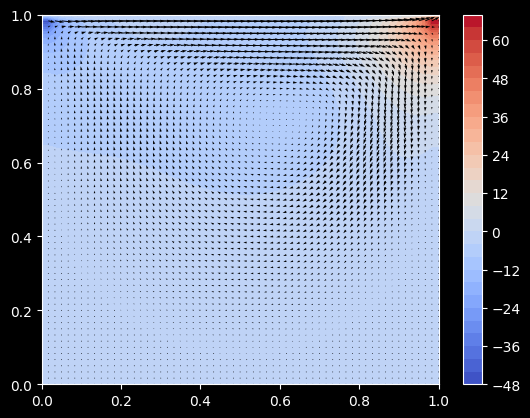

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


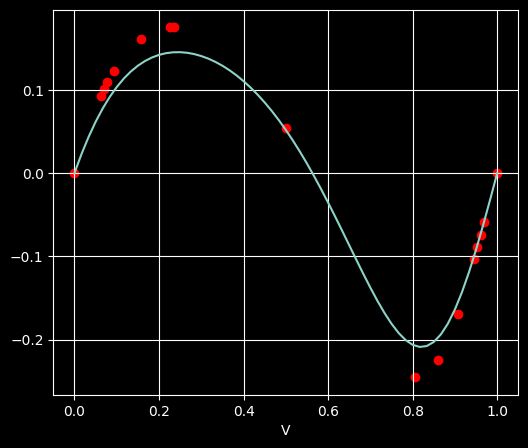

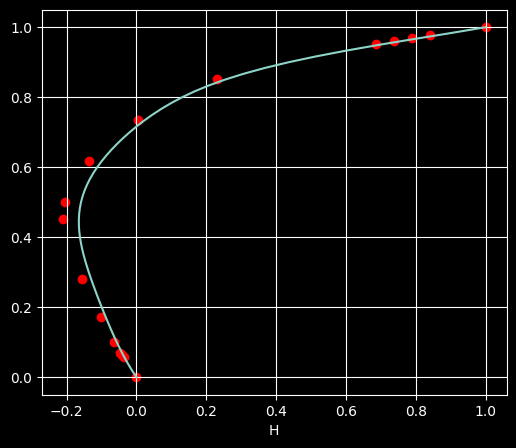

In [27]:
"""
Solves the incompressible Navier Stokes equations in a lid-driven cavity
scenario using Finite Differences, explicit timestepping and Chorin's Projection.

Momentum:           ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f

Incompressibility:  ∇ ⋅ u = 0


u:  Velocity (2d vector)
p:  Pressure
f:  Forcing (here =0)
ν:  Kinematic Viscosity
ρ:  Density
t:  Time
∇:  Nabla operator (defining nonlinear convection, gradient and divergence)
∇²: Laplace Operator

----

Lid-Driven Cavity Scenario:


                            ------>>>>> u_top

          1 +-------------------------------------------------+
            |                                                 |
            |             *                      *            |
            |          *           *    *    *                |
        0.8 |                                                 |
            |                                 *               |
            |     *       *                                   |
            |                      *     *                    |
        0.6 |                                            *    |
u = 0       |      *                             *            |   u = 0
v = 0       |                             *                   |   v = 0
            |                     *                           |
            |           *                *         *          |
        0.4 |                                                 |
            |                                                 |
            |      *            *             *               |
            |           *                             *       |
        0.2 |                       *           *             |
            |                               *                 |
            |  *          *      *                 *       *  |
            |                            *                    |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

                                    u = 0
                                    v = 0

* Velocity and pressure have zero initial condition.
* Homogeneous Dirichlet Boundary Conditions everywhere except for horizontal
  velocity at top. It is driven by an external flow.

-----

Solution strategy:   (Projection Method: Chorin's Splitting)

1. Solve Momentum equation without pressure gradient for tentative velocity
   (with given Boundary Conditions)

    ∂u/∂t + (u ⋅ ∇) u = ν ∇²u

2. Solve pressure poisson equation for pressure at next point in time
   (with homogeneous Neumann Boundary Conditions everywhere except for
   the top, where it is homogeneous Dirichlet)

    ∇²p = ρ/Δt ∇ ⋅ u

3. Correct the velocities (and again enforce the Velocity Boundary Conditions)

    u ← u − Δt/ρ ∇ p

-----

    Expected Outcome: After some time a swirling motion will take place

          1 +-------------------------------------------------+
            |                                                 |
            |                                                 |
            |                                                 |
        0.8 |                                                 |
            |                      *-->*                      |
            |                ******     ******                |
            |              **                 **              |
        0.6 |             *                     *             |
            |             *                      *            |
            |            *                        *           |
            |            *                       *            |
            |             *                     *             |
        0.4 |             *                     *             |
            |              **                 **              |
            |                ******     ******                |
            |                      *<--*                      |
        0.2 |                                                 |
            |                                                 |
            |                                                 |
            |                                                 |
          0 +-------------------------------------------------+
            0        0.2       0.4       0.6       0.8        1

------

Strategy in index notation

u = [u, v]
x = [x, y]

1. Solve tentative velocity + velocity BC

    ∂u/∂t + u ∂u/∂x + v ∂u/∂y = ν ∂²u/∂x² + ν ∂²u/∂y²

    ∂v/∂t + u ∂v/∂x + v ∂v/∂y = ν ∂²v/∂x² + ν ∂²v/∂y²

2. Solve pressure poisson + pressure BC

    ∂²p/∂x² + ∂²p/∂y² = ρ/Δt (∂u/∂x + ∂v/∂y)

3. Correct velocity + velocity BC

    u ← u − Δt/ρ ∂p/∂x

    v ← v − Δt/ρ ∂p/∂y

------

IMPORTANT: Take care to IMPORTANT: Take care to select a timestep that ensures stability
"""

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

# Constants
N_points = 61
domain_size = 1.0
N_interactions = 5_000
time_step_lenght = 0.0005
kinematic_viscosity = 0.1
density = 1.0
horizontal_velocity_top = 10.0
Reynolds = horizontal_velocity_top * domain_size / kinematic_viscosity

N_pressure_poissson_interactions = 50



#Try the stability

Stabilization_factor = 0.75
delta_x = domain_size / (N_points-1)
Courant_number= ( horizontal_velocity_top * time_step_lenght / delta_x)

print("Courant Number is "+ str(Courant_number))
if Courant_number >  1.0:
  print("Courant Number is high, changing the time step to a lower value!!")
  time_step_lenght  = Stabilization_factor * delta_x / horizontal_velocity_top
  print("The new Time Step is:" + str(time_step_lenght))
  Courant_number= ( horizontal_velocity_top * time_step_lenght / delta_x)
  print("Courant Number is now  equal to:" + str(Courant_number))



def main():
  element_lengh = domain_size / (N_points-1)

  #nodes
  x = np.linspace(0.0, domain_size, N_points)
  y = np.linspace(0.0, domain_size, N_points)

  #mesh grid
  X, Y = np.meshgrid (x, y)

  #initial conditions
  u_prev = np.zeros_like(X)
  v_prev = np.zeros_like(Y)
  p_prev = np.zeros_like(X)   # X does have the sasme dimension of Y

  # central difference in X direction
  def central_diff_x(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1,2: ]
        -
        f[1:-1, 0:-2]
    )/(
         2 * element_lengh
    )
    return diff

  # central difference in Y direction
  def central_diff_y(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[2:  , 1:-1]
        -
        f[0: -2, 1:-1]
    )/(
        2 * element_lengh
    )
    return diff

  #laplace operator discretization
  def laplace(f):
    diff = np.zeros_like(f)
    diff[1:-1,1:-1] = (

        f[1:-1, 0:-2]
        +
        f[0:-2, 1:-1]
        -
        4
        *
        f[1:-1, 1:-1]
        +
        f[1:-1, 2:  ]
        +
        f[2:  , 1:-1]
    )/(
        element_lengh**2
    )
    return diff





  #from tqdm import tqdm
  for _ in tqdm(range(N_interactions)):
    du_prev_dx = central_diff_x(u_prev)
    du_prev_dy = central_diff_y(u_prev)
    dv_prev_dx = central_diff_x(v_prev)
    dv_prev_dy = central_diff_y(v_prev)
    laplace_u_prev = laplace(u_prev)
    laplace_v_prev = laplace(v_prev)

    # perform a tentative setp by solving the momentum equations
    # without pressure gradient

    u_tent = (
        u_prev
        +
        time_step_lenght * (
            -
            (
                u_prev * du_prev_dx
                +
                v_prev * du_prev_dy
            )
            +
            kinematic_viscosity * laplace_u_prev
        )
    )
    v_tent = (
        v_prev
        +
        time_step_lenght * (
            -
            (
                u_prev * dv_prev_dx
                +
                v_prev * dv_prev_dy
            )
            +
            kinematic_viscosity * laplace_v_prev
        )
    )

    #velocity boundary conditions: homogeneuous
    # except on the top lid
    u_tent[0, :] = 0.0
    u_tent[:, 0] = 0.0
    u_tent[:, -1] = 0.0
    u_tent[-1, :] = horizontal_velocity_top
    v_tent[0, :] = 0.0
    v_tent[:, 0] = 0.0
    v_tent[:, -1] = 0.0
    v_tent[-1, :] = 0.0

    # divergence of velocity
    du_tent_dx = central_diff_x(u_tent)
    dv_tent_dy = central_diff_y(v_tent)

    #Pressure correction by solving the pressure-poisson equation
    # right-ahnd-side ( the source of pressure-poisson equation)
    rhs = (
        density / time_step_lenght
        *
        (
            du_tent_dx
            +
            dv_tent_dy
        )
    )

    for _ in range(N_pressure_poissson_interactions):
      p_next = np.zeros_like(p_prev)
      p_next[1:-1, 1:-1] = 1/4 * (
          +
          p_prev[1:-1, 0:-2]
          +
          p_prev[0:-2, 1:-1]
          +
          p_prev[1:-1, 2:  ]
          +
          p_prev[2:  , 1:-1]
          -
          element_lengh**2
          *
          rhs[1:-1, 1:-1]
      )

      #pressure  BC : homogeneous Neumann BC
      #except on the Top Lid -> homogenenous Dirichlet BC
      p_next[:, -1] = p_next[:, -2]
      p_next[0, : ] = p_next[1,  :]
      p_next[:,  0] = p_next[:,  1]
      p_next[-1, :] = 0.0

      p_prev = p_next

    dp_next_dx = central_diff_x(p_next)
    dp_next_dy = central_diff_y(p_next)

    # Correction of velocities -> making it incompressible

    u_next = (
        u_tent
        -
        time_step_lenght / density
        *
        dp_next_dx
    )
    v_next = (
        v_tent
        -
        time_step_lenght / density
        *
        dp_next_dy
    )
     #velocity boundary conditions: homogeneuous
    # except on the top lid
    u_next[0, :] = 0.0
    u_next[:, 0] = 0.0
    u_next[:, -1] = 0.0
    u_next[-1, :] = horizontal_velocity_top
    v_next[0, :] = 0.0
    v_next[:, 0] = 0.0
    v_next[:, -1] = 0.0
    v_next[-1, :] = 0.0

    # Advance in Time

    #relaxations W
    w = 0.5
    u_prev = w * u_next + (1-w) * u_prev
    v_prev = w * v_next + (1-w) * v_prev
    p_prev = w * p_next + (1-w) * p_prev
    v_magnitude = np.sqrt(u_next**2 + v_next**2)


# The [::2, ::2] selects only every second entry (less cluttering plot)
  plt.style.use("dark_background")
  plt.figure()
  plt.contourf(X[::1, ::1], Y[::1, ::1], p_next[::1, ::1], cmap="coolwarm", levels =31)
  plt.colorbar()

  plt.quiver(X[::1, ::1], Y[::1, ::1], u_next[::1, ::1], v_next[::1, ::1], color="black")
  # plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
  plt.xlim((0, 1))
  plt.ylim((0, 1))
  plt.show()



  # Comparison with Literature

  from google.colab import drive

  drive.mount('/content/drive')
  U_data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Re100_U.dat',delimiter='\t')
  U_data = U_data.astype(float)
  V_data = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Re100_V.dat', delimiter='\t')
  V_data = V_data.astype(float)
  xdata = V_data['x[m]']
  ydata = V_data['V_Guia']

  linha_central_horizontal_U  = u_next[ : , N_points//2]
  linha_central_vertical_V  = v_next[ N_points//2, : ]

  plt.figure(figsize=(6, 5))
  plt.plot(x, linha_central_vertical_V/horizontal_velocity_top, label='Componente V')
  plt.scatter(xdata, ydata, label='Guia',color='red')
  plt.xlabel('L')
  plt.xlabel('V')
  plt.grid()
  plt.show()


  xdata = U_data['y[m]']
  ydata = U_data['U_Guia']
  plt.figure(figsize=(6, 5))
  plt.plot(linha_central_horizontal_U/horizontal_velocity_top, y , label='Componente U')
  plt.scatter(ydata, xdata, label='Guia',color='red')
  plt.xlabel('U')
  plt.xlabel('H')
  plt.grid()
  plt.show()

if __name__ == "__main__":
  main()
